# Machine Learning Project : To bee or not to bee
___

## 1. Business Understanding

* Context : Pollinator insects such as bees and bumblebees are important for ecosystems diversity and by fertilizing flowers, they play a vital role in the global food chain system.
* Problem : Distinguishing bee types amongst pollinators is crucial in this context and traditional methods which are mostly manual are quite time-consuming especially with our dataset of 250 images, although it might be less prone to error
* Solution : This project aims to leverage Machine Learning (ML), Deep Learning and Ai & Optimization techniques to automate the identification process by looking at an image (and its mask) and recognize the bug type and in a later time its species.
* Stakeholders : This project would interest more than one amongst researches, within the agricultural sector as well as for educational purposes.

Now that we're well versed in the subject of this project we can get into the technicalities

In [159]:
pip install xgboost

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/150.0 MB 4.2 MB/s eta 0:00:36
   ---------------------------------------- 1.3/150.0 MB 4.2 MB/s eta 0:00:36
    --------------------------------------- 2.4/150.0 MB 4.5 MB/s eta 0:00:34
    --------------------------------------- 3.7/150.0 MB 4.7 MB/s eta 0:00:31
   - -------------------------------------- 4.5/150.0 MB 4.9 MB/s eta 0:00:30
   - -------------------------------------- 5.2/150.0 MB 4.5 MB/s eta 0:00:33
   - -------------------------------------- 6.0/150.0 MB 4.3 MB/s eta 0:00:34
   - -------------------------------------- 6.8/150.0 MB 4.3 MB/s eta 0:00:34
   - -------------------------------------- 7.3/150.0 MB 4.1 MB/s eta 0:00:35
   -- ------------------------------------- 8.7/150.0 MB 4.3 MB/s eta 0:00:33
   -- ------------------------------------- 9.7/150.0 MB 4.4 MB/s eta 0:00:33
   --- ------------------------------------ 11.3/150.0 MB 4.7 MB/s eta 

## 2. Data Understanding

In [160]:
# We need to import the necessary libraries 
import warnings
import cv2
import os
import numpy as np
from tqdm.notebook import tqdm 
import re
import matplotlib.pyplot as plt
from PIL import Image
from scipy.optimize import minimize
import scipy.ndimage as ndi
import datetime
from time import process_time
import glob
import pandas as pd
from skimage import measure
import scipy.ndimage as ndi
from multiprocessing import Pool, cpu_count
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap 
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score, classification_report
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTEENN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization 
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau 
from tensorflow.keras.utils import to_categorical
from collections import Counter
from sklearn.utils import class_weight
import xgboost as xgb
warnings.filterwarnings('ignore')

### Configuration

In [2]:
IMAGE_FOLDER = 'tobeeornottobee_train_v2/train' 
MASK_FOLDER = 'tobeeornottobee_train_v2/train/masks'  
MASK_FILE_EXTENSION = '.tif'
EXPECTED_TRAINING_FILES = 250
LABELS_PATH = 'tobeeornottobee_train_v2/train/classif.xlsx'

### Dataset Loading

In [3]:
training_data = [] # we will store each image and its mask identified by a unique ID (seq(0,250))

try:
    # list the files in IMAGE_FOLDER.
    all_files_in_image_folder = os.listdir(IMAGE_FOLDER)

    # keep only the .jpg files (filter out the /mask folder)
    image_filenames = [f for f in all_files_in_image_folder if f.lower().endswith('.jpg')]

    # sort the filenames numerically 
    # since our files aren't formatted such as 001, 002 if we keep them this way 100 will be before 2 
    def sort_key(filename):
        match = re.match(r'(\d+)\.jpg', filename, re.IGNORECASE) # find number (digits) before the extension
        return int(match.group(1))
    image_filenames.sort(key=sort_key)

    # make sure we have 250 files loaded so far
    files_to_load = image_filenames[:EXPECTED_TRAINING_FILES]
    if len(files_to_load) < EXPECTED_TRAINING_FILES:
        print(f"⚠️: Loading {len(files_to_load)} files.")
    else:
        print(f"Loading the {len(files_to_load)} files based on sorted filenames.")

    for img_filename in tqdm(files_to_load, desc="Processing Files"):

        # getting the name that will serve as ID as well
        image_id = os.path.splitext(img_filename)[0]

        # creating full path to the image file
        image_path = os.path.join(IMAGE_FOLDER, img_filename)

        # finding expected filename for the corresponding mask.
        mask_filename = "binary_" + image_id + MASK_FILE_EXTENSION # e.g., "binary_1.tif"
        # creating full path to the mask file
        mask_path = os.path.join(MASK_FOLDER, mask_filename)
        
        # load the image using OpenCV (BGR format by default in OpenCV)
        image = cv2.imread(image_path)
        if image is None:
            print(f"  ⚠️: Could not read image file: '{image_path}'. Skipping this pair.") # check if loading works
            continue 

        # load the mask as Grayscale (single channel) using OpenCV
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            print(f"  ⚠️: Could not read mask file: '{mask_path}'. Skipping this pair.") # check if loading worked.
            continue

        # finallt, store the loaded data in our list.
        data_item = {
            'id': image_id,        # The identifier (e.g., '1', '123')
            'image': image,        # The loaded image 
            'mask': mask           # The loaded mask (corresponding to the image)
        }
        training_data.append(data_item)

    print(f"\nFinished loading. Successfully loaded {len(training_data)} image/mask pairs.")

except FileNotFoundError:
    print("Error in paths")
    training_data = [] # Ensure data list is empty if loading failed
except Exception as e:
    print("An unexpected error occurred")
    print(e)
    training_data = []

Loading the 250 files based on sorted filenames.


Processing Files:   0%|          | 0/250 [00:00<?, ?it/s]


Finished loading. Successfully loaded 250 image/mask pairs.


**Our mask "binary_154.tif" doesn't exist in the dataset : We will create it on our own.**

Loaded image: tobeeornottobee_train_v2/train\154.JPG with shape (4000, 6000, 3)


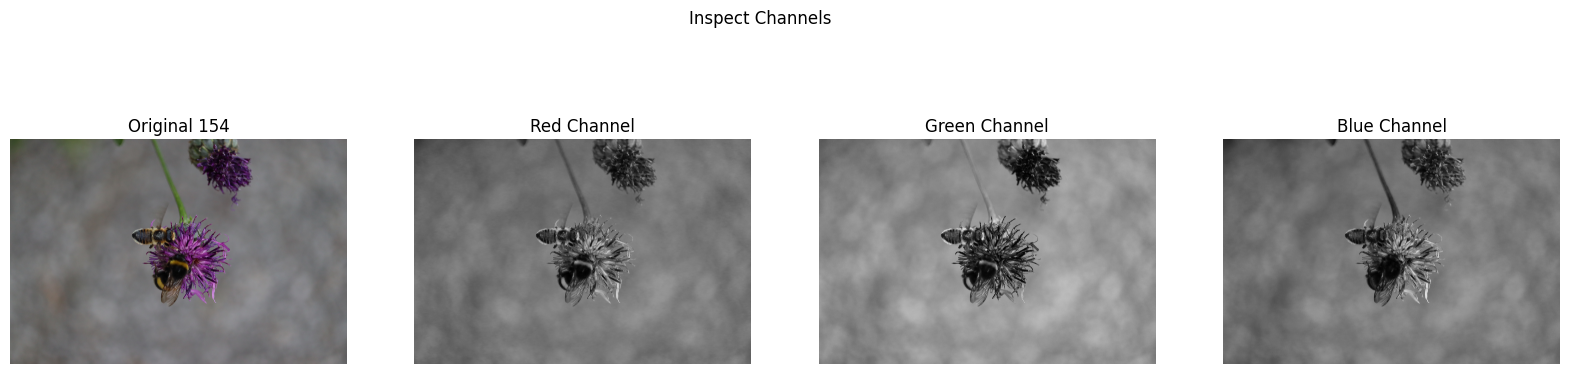

In [4]:
IMAGE_ID_TO_PROCESS = "154" 
IMAGE_EXTENSION = ".JPG" 

# --- Load the image ---
image_filename = f"{IMAGE_ID_TO_PROCESS}{IMAGE_EXTENSION}"
image_path = os.path.join(IMAGE_FOLDER, image_filename)

try:
    # Load
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        raise FileNotFoundError(f"Image not found at {image_path}")
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # Convert to RGB 
    img_arr = img_rgb # processing

    print(f"Loaded image: {image_path} with shape {img_arr.shape}")

except FileNotFoundError:
    print(f"⚠️: Could not load the image {image_path}.")
    exit()
except Exception as e:
    print(f"⚠️: An error occurred loading the image: {e}")
    exit()


# --- 1. Inspecting channels & choosing one for thresholding ---
fig, ax = plt.subplots(1, 4, figsize=(20, 5)) 
ax[0].imshow(img_arr)
ax[0].set_title(f'Original {IMAGE_ID_TO_PROCESS}')
ax[0].axis('off')

if img_arr.ndim == 3 and img_arr.shape[2] == 3:
    titles = ['Red Channel', 'Green Channel', 'Blue Channel']
    for i in range(3):
        ax[i+1].imshow(img_arr[:, :, i], cmap='gray')
        ax[i+1].set_title(titles[i])
        ax[i+1].axis('off')
else: # Grayscale image (should ideally be 3-channel from loading)
    ax[1].imshow(img_arr, cmap='gray')
    ax[1].set_title('Grayscale Image')
    ax[1].axis('off')
    for i in range(2,4): ax[i].axis('off') # Hide unused plots

plt.suptitle("Inspect Channels")
plt.show()

*The threshholding strategy is to look for darker pixels: while in the red and green channels the yellow bumblebee parts are bright, they're on the darker side in the blue channel so that's what we'll choose*

Calculated threshold for inversion: 83.0


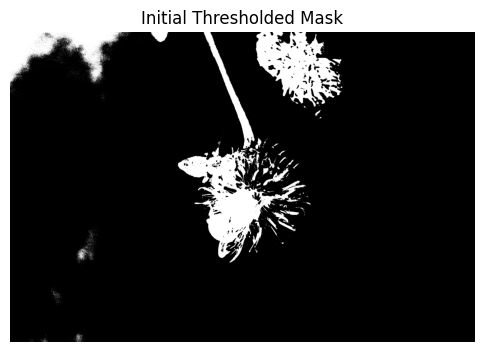

In [5]:
chosen_channel_index = 2 
process_channel_arr = img_arr[:, :, chosen_channel_index]

# --- 2. Thresholding ---
ret, initial_mask_arr_otsu = cv2.threshold(process_channel_arr, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
initial_mask_arr = initial_mask_arr_otsu # This is 0 for background, 255 for foreground (bug)
print(f"Calculated threshold for inversion: {ret}")

# Display the initial thresholded mask
plt.figure(figsize=(6,6))
plt.imshow(initial_mask_arr, cmap='gray')
plt.title("Initial Thresholded Mask")
plt.axis('off')
plt.show()

# Convert to 0 and 1 for ndi functions
if np.max(initial_mask_arr) > 1:
    mask_for_ndi = (initial_mask_arr / 255).astype(np.uint8)
else:
    mask_for_ndi = initial_mask_arr.astype(np.uint8)

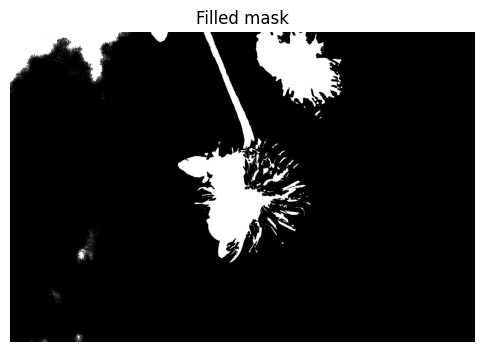

In [6]:
# --- 3. Filling the hole ---
filled_mask_arr = ndi.binary_fill_holes(mask_for_ndi).astype(np.uint8)

plt.figure(figsize=(6,6))
plt.imshow(filled_mask_arr, cmap='gray')
plt.title("Filled mask")
plt.axis('off')
plt.show()

9580 connected components found in the hole-filled mask.
Selected largest component (ID: 5889, Area: 794054)


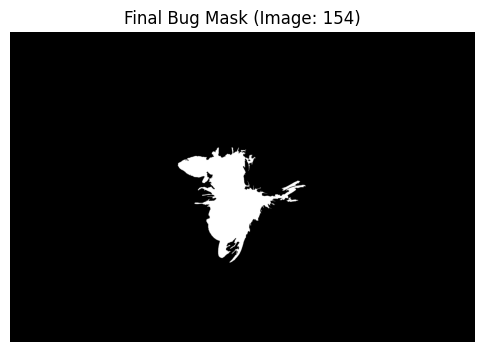

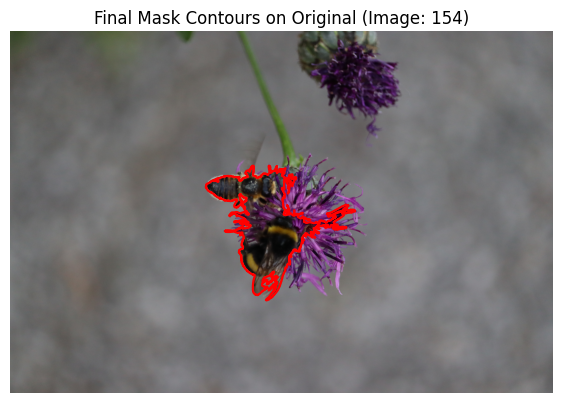

In [7]:
# --- 4. Connected components & selection ---
ccs_arr, nb_ccs = ndi.label(filled_mask_arr)
print(f'{nb_ccs} connected components found in the hole-filled mask.')

if nb_ccs == 0:
    print("No components found.")
    final_bug_mask = np.zeros_like(filled_mask_arr, dtype=np.uint8)
else:
    cc_ids, cc_areas = np.unique(ccs_arr[ccs_arr > 0], return_counts=True)
    if len(cc_ids) > 0:
        largest_cc_id = cc_ids[np.argmax(cc_areas)]
        final_bug_mask_0_1 = (ccs_arr == largest_cc_id).astype(np.uint8)
        print(f"Selected largest component (ID: {largest_cc_id}, Area: {np.max(cc_areas)})")

        # A final hole fill on the selected component
        final_bug_mask_0_1 = ndi.binary_fill_holes(final_bug_mask_0_1).astype(np.uint8)
        
        # Convert to 0 and 255 for saving as a typical binary image mask
        final_bug_mask = final_bug_mask_0_1 * 255

    else:
        print("No foreground components identified after unique counts.")
        final_bug_mask = np.zeros_like(filled_mask_arr, dtype=np.uint8)


# Display the final selected bug mask
plt.figure(figsize=(6,6))
plt.imshow(final_bug_mask, cmap='gray')
plt.title(f"Final Bug Mask (Image: {IMAGE_ID_TO_PROCESS})")
plt.axis('off')
plt.show()

# Display contours on original image
plt.figure(figsize=(7,7))
plt.imshow(img_arr) # Show original RGB
plt.contour(final_bug_mask, levels=[127], colors='r', linewidths=1.5) # levels=[0.5] if mask is 0-1
plt.title(f"Final Mask Contours on Original (Image: {IMAGE_ID_TO_PROCESS})")
plt.axis('off')
plt.show()

*The results are pretty satisfying so we save the mask*

In [8]:
# --- 5. Save the mask ---
mask_save_filename = f"binary_{IMAGE_ID_TO_PROCESS}{MASK_FILE_EXTENSION}"
mask_save_path = os.path.join(MASK_FOLDER, mask_save_filename)

if os.path.exists(mask_save_path):
    print("You're re-running so the mask has already been saved")
else:
    try:
        # Ensure final_bug_mask is uint8
        final_bug_mask_uint8 = final_bug_mask.astype(np.uint8)
        
        success = cv2.imwrite(mask_save_path, final_bug_mask_uint8)
        if success:
            print(f"Successfully saved mask to: {mask_save_path}")
            
            data_item = {
                'id': IMAGE_ID_TO_PROCESS,
                'image': img_bgr,
                'mask': final_bug_mask
            }
            training_data.append(data_item)
        else:
            print(f"Failed to save mask to: {mask_save_path}")
    except Exception as e:
        print(f"Error saving mask: {e}")


You're re-running so the mask has already been saved


### Feature Extraction

Defining helper functions derived from the AI & Optimization LAB 

However, We'll use ndi for rotation instead of matrixes to avoid time-consuming iterations

In [9]:
def rotate_image_for_symmetry(image_arr, angle_degrees, center_x, center_y):
    rotated_mask = ndi.rotate(image_arr, angle=angle_degrees, reshape=False, 
                               mode='constant', cval=0, order=0)
    return (rotated_mask > 0.5).astype(np.uint8)

In [10]:
def inscribed_circle_loss(params, distance_transform, shape):
    radius, cx, cy = params
    if radius <= 0: return 1e6 
    cx_int, cy_int = int(round(cx)), int(round(cy))
    if not (0 <= cx_int < shape[0] and 0 <= cy_int < shape[1]):
        return 1e6 + (radius**2)
    max_r_at_center = distance_transform[cx_int, cy_int]
    loss = -radius 
    if radius > max_r_at_center + 1e-2 : 
        loss += (radius - max_r_at_center)**2 * 100 
    if radius < 0.1: 
        loss += (0.1 - radius)**2 * 10 
    return loss

In [11]:
def get_mirrored_mask(mask, axis_coord, axis_orientation='vertical'):
    if axis_orientation == 'vertical': return np.fliplr(mask)
    else: return np.flipud(mask)

In [12]:
def symmetry_loss(angle_degrees, original_mask, center_x, center_y, weight_mask=None):
    if isinstance(angle_degrees, (np.ndarray, list, tuple)): # Ensure scalar angle
        current_angle = angle_degrees[0]
    else:
        current_angle = angle_degrees
    rotated_mask = rotate_image_for_symmetry(original_mask, current_angle, center_x, center_y)
    mirrored_rotated_mask = get_mirrored_mask(rotated_mask, axis_coord=rotated_mask.shape[1] // 2, axis_orientation='vertical')
    diff = np.sum(np.logical_xor(rotated_mask, mirrored_rotated_mask))
    return float(diff)

Main logic for feature extraction to implement 

In [13]:
def extract_features(image_id, image_rgb_arr_input, mask_binary_arr_input):
    features = {'id': image_id}
    boolean_mask = mask_binary_arr_input.astype(bool)
    num_bug_pixels = np.sum(mask_binary_arr_input)

    feature_names = [
        # 1. The shape and symmetry measures
        'shape_eccentricity', 'shape_solidity',
        'inscribed_circle_radius', 
        'symmetry_angle', 
        'symmetry_score', 
        # 2. The ratio of the number of pixels of bug divided by the number of pixels of the full image
        'pixel_ratio_bug_to_total',
        
        # 3. The min, max and mean values for Red, Green and Blue within the bug mask.
        # The median and standard deviation for the Red, Green and Blue within the bug mask
        'R_min', 'R_max', 'R_mean', 'R_median', 'R_std',
        'G_min', 'G_max', 'G_mean', 'G_median', 'G_std',
        'B_min', 'B_max', 'B_mean', 'B_median', 'B_std',
        
        'bug_area', 'bbox_aspect_ratio', # Axis-aligned
        
        # (Optional) Oriented Bounding Box features (features from Lab 1) - now using cv2.minAreaRect
        'obb_angle', # Using your preferred name
        'obb_area', 
        'obb_aspect_ratio', 
        'mask_area_to_obb_area_ratio', 
        
        # 4. At least two other features of your choosing
        'hu_moment_1', 'hu_moment_2'
    ]

    for name in feature_names: features[name] = np.nan
    features['pixel_ratio_bug_to_total'] = 0.0 
    features['bug_area'] = 0

    if num_bug_pixels == 0:
        # print(f"⚠️: Mask for image {image_id} is empty.")
        return features 

    # --- Core features ---
    features['bug_area'] = num_bug_pixels
    label_img_sk = measure.label(mask_binary_arr_input)
    props_list_sk = measure.regionprops(label_img_sk, intensity_image=image_rgb_arr_input)
    
    # --- Define mask_centroid_row and mask_centroid_col consistently ---
    # These will be used as initial guesses for inscribed circle.
    # Convention: (row, col) matching NumPy array indexing.
    mask_centroid_row, mask_centroid_col = np.nan, np.nan 

    if props_list_sk:
        bug_props_sk = props_list_sk[0]
        features['shape_eccentricity'] = bug_props_sk.eccentricity
        features['shape_solidity'] = bug_props_sk.solidity
        minr, minc, maxr, maxc = bug_props_sk.bbox
        bbox_height = maxr - minr + 1 
        bbox_width = maxc - minc + 1  
        features['bbox_aspect_ratio'] = bbox_height / bbox_width if bbox_width > 0 else np.nan
        
        # skimage centroid is (row, col)
        mask_centroid_row, mask_centroid_col = bug_props_sk.centroid 
        
    # In case of failure of regionprops (or if it's empty for some reason, though num_bug_pixels > 0)
    if np.isnan(mask_centroid_row) or np.isnan(mask_centroid_col):
        rows_fallback, cols_fallback = np.where(mask_binary_arr_input > 0)
        if rows_fallback.size > 0: # Ensure there are actually pixels
            mask_centroid_row = np.mean(rows_fallback)
            mask_centroid_col = np.mean(cols_fallback)
        else:
            mask_centroid_row = mask_binary_arr_input.shape[0] / 2.0
            mask_centroid_col = mask_binary_arr_input.shape[1] / 2.0
        
    total_pixels = image_rgb_arr_input.shape[0] * image_rgb_arr_input.shape[1]
    if total_pixels > 0 :
        features['pixel_ratio_bug_to_total'] = num_bug_pixels / total_pixels
        
    for i, color_char in enumerate(['R', 'G', 'B']):
        channel_pixels = image_rgb_arr_input[:, :, i][boolean_mask]
        if channel_pixels.size > 0: 
            features[f'{color_char}_min'] = np.min(channel_pixels)
            features[f'{color_char}_max'] = np.max(channel_pixels)
            features[f'{color_char}_mean'] = np.mean(channel_pixels)
            features[f'{color_char}_median'] = np.median(channel_pixels)
            features[f'{color_char}_std'] = np.std(channel_pixels)


    # --- Oriented Bounding Box ---
    # We will be using cv2.minAreaRect instead of manual computation with matrices for speed
    contours_obb, _ = cv2.findContours(mask_binary_arr_input.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours_obb and len(contours_obb) > 0:
        main_contour_obb = max(contours_obb, key=cv2.contourArea)
        rect_obb = cv2.minAreaRect(main_contour_obb) 
        
        obb_width, obb_height = rect_obb[1] 
        obb_angle_cv = rect_obb[2] # Angle from cv2

        # ensure width <= height for consistent aspect ratio for OBB
        if obb_width > obb_height:
            obb_width, obb_height = obb_height, obb_width
        
        features['obb_angle'] = obb_angle_cv # Storing the raw angle from cv2.minAreaRect

        obb_computed_area = obb_width * obb_height
        features['obb_area'] = obb_computed_area
        
        if obb_width > 1e-3: # tolerance
            features['obb_aspect_ratio'] = obb_height / obb_width # Major axis / Minor axis
        
        if obb_computed_area > 1e-3: # tolerance
            features['mask_area_to_obb_area_ratio'] = num_bug_pixels / obb_computed_area


    # --- Inscribed Circle (project_extra_features.pdf) ---
    # These variables will store the optimized/best inscribed circle center for symmetry calculation
    internal_ic_center_final_row, internal_ic_center_final_col = np.nan, np.nan 
    
    distance_transform = ndi.distance_transform_edt(mask_binary_arr_input)
    max_radius_from_dt = 0.1
    # Default for DT max location if DT is empty or all zero
    center_coords_dt_from_max_row = mask_centroid_row # Use calculated mask centroid as better default
    center_coords_dt_from_max_col = mask_centroid_col

    if distance_transform.size > 0 and np.any(distance_transform):
        max_radius_from_dt = np.max(distance_transform)
        dt_max_idx_row, dt_max_idx_col = np.unravel_index(np.argmax(distance_transform), distance_transform.shape)
        center_coords_dt_from_max_row = dt_max_idx_row
        center_coords_dt_from_max_col = dt_max_idx_col

    # Use general mask centroid (mask_centroid_row, mask_centroid_col) as initial guess for inscribed circle center
    # Parameters for inscribed_circle_loss: radius, center_row, center_col
    initial_ic_center_row_guess = mask_centroid_row 
    initial_ic_center_col_guess = mask_centroid_col
    
    cr_int_guess, cc_int_guess = int(round(initial_ic_center_row_guess)), int(round(initial_ic_center_col_guess))
    initial_ic_radius_guess = 1.0
    if 0 <= cr_int_guess < distance_transform.shape[0] and 0 <= cc_int_guess < distance_transform.shape[1]:
        initial_ic_radius_guess = distance_transform[cr_int_guess, cc_int_guess]
    initial_ic_radius_guess = max(0.1, min(initial_ic_radius_guess, min(mask_binary_arr_input.shape)/3, max_radius_from_dt + 0.5))

    initial_params_ic = [initial_ic_radius_guess, initial_ic_center_row_guess, initial_ic_center_col_guess]
    param_bounds_ic = [(0.1, max(1.0, max_radius_from_dt * 1.2)), 
                       (0, mask_binary_arr_input.shape[0]-1), # Bounds for center_row
                       (0, mask_binary_arr_input.shape[1]-1)] # Bounds for center_col
    
    try:
        res_circle = minimize(inscribed_circle_loss, initial_params_ic, 
                              args=(distance_transform, mask_binary_arr_input.shape), 
                              method='L-BFGS-B', bounds=param_bounds_ic,
                              options={'maxiter': 10, 'ftol': 1e-3, 'eps': 1e-3})

        best_r, best_cr_ic, best_cc_ic = initial_params_ic # Default values
        opt_success_ic = False
        if res_circle.success or 'CONVERGENCE' in res_circle.message.upper():
            best_r, best_cr_ic, best_cc_ic = res_circle.x
            opt_success_ic = True
            bcr_int, bcc_int = int(round(best_cr_ic)), int(round(best_cc_ic))
            if 0 <= bcr_int < distance_transform.shape[0] and 0 <= bcc_int < distance_transform.shape[1]:
                max_possible_at_opt_center = distance_transform[bcr_int, bcc_int]
                if best_r > max_possible_at_opt_center + 0.5: best_r = max_possible_at_opt_center
            else: opt_success_ic = False
        
        if not opt_success_ic or best_r <= 0.1:
            features['inscribed_circle_radius'] = max(0.1, max_radius_from_dt)
            internal_ic_center_final_row = center_coords_dt_from_max_row 
            internal_ic_center_final_col = center_coords_dt_from_max_col 
        else:
            features['inscribed_circle_radius'] = max(0.1, best_r)
            internal_ic_center_final_row = best_cr_ic 
            internal_ic_center_final_col = best_cc_ic 
            
    except Exception as e_circle:
        # print(f"⚠️: Error during inscribed circle optimization for {image_id}: {e_circle}.") # Your comment
        features['inscribed_circle_radius'] = max(0.1, max_radius_from_dt)
        internal_ic_center_final_row = center_coords_dt_from_max_row
        internal_ic_center_final_col = center_coords_dt_from_max_col


    # --- Best symmetry plane (project_extra_features.pdf) ---
    # Uses internal_ic_center_final_row, internal_ic_center_final_col
    if not (np.isnan(internal_ic_center_final_row) or np.isnan(internal_ic_center_final_col)):
        center_ic_row_for_symmetry = internal_ic_center_final_row # This is row
        center_ic_col_for_symmetry = internal_ic_center_final_col # This is col

        try:
            test_sym_angles = np.arange(0, 181, 30) 
            # Pass center_row, center_col to symmetry_loss
            losses_sym = [symmetry_loss(angle, mask_binary_arr_input, 
                                         center_ic_row_for_symmetry, center_ic_col_for_symmetry, None) 
                          for angle in test_sym_angles]
            initial_sym_angle_guess = test_sym_angles[np.argmin(losses_sym)] if losses_sym else 0

            res_sym = minimize(symmetry_loss, initial_sym_angle_guess,
                               args=(mask_binary_arr_input, center_ic_row_for_symmetry, center_ic_col_for_symmetry, None),
                               method='Nelder-Mead',
                               options={'maxiter': 10, 'xatol': 2e-1, 'fatol': 2e-1})

            best_sym_angle = initial_sym_angle_guess
            min_sym_loss = np.min(losses_sym) if losses_sym else np.inf

            if res_sym.success or 'iteration limit' in res_sym.message.lower():
                res_x_sym = res_sym.x
                if isinstance(res_x_sym, (np.ndarray, list, tuple)): best_sym_angle = res_x_sym[0] % 180
                else: best_sym_angle = res_x_sym % 180
                min_sym_loss = res_sym.fun if res_sym.fun is not None else min_sym_loss

            features['symmetry_angle'] = best_sym_angle
            features['symmetry_score'] = min_sym_loss
        except Exception as e_sym:
            print(f"⚠️: Error during symmetry plane optimization for {image_id}: {e_sym}") 
    else:
        print(f"⚠️: Missing inscribed circle center.") 
        
    # --- Additional chosen features ---
    # Feature 1 & 2: Hu Moments 
    # Hu Moments ( or rather Hu moment invariants ) are a set of 7 numbers calculated using central moments (first 6) that are 
    # invariant to image transformations. (source: https://learnopencv.com/shape-matching-using-hu-moments-c-python/)
    moments = cv2.moments(mask_binary_arr_input) 
    hu_moments = cv2.HuMoments(moments).flatten()
    features['hu_moment_1'] = hu_moments[0] if len(hu_moments) > 0 else np.nan
    features['hu_moment_2'] = hu_moments[1] if len(hu_moments) > 1 else np.nan
        
    return features

Feature extraction loop

In [35]:
features_save_path = "extracted_bee_project_features.csv"

if os.path.exists(features_save_path):
    print("You're re-running so the features have already been extracted and saved")
    features_df = pd.read_csv(features_save_path, sep=";")
else:
    all_extracted_features = []

    if training_data: # check if data was loaded successfully
        print(f"\nStarting feature extraction for {len(training_data)} items...")
        for item in tqdm(training_data, desc="Extracting Features"):
            image_id_str = item['id']
            image_bgr_arr = item['image']       
            mask_grayscale_arr = item['mask']  

            # BGR to RGB 
            image_rgb_for_function = cv2.cvtColor(image_bgr_arr, cv2.COLOR_BGR2RGB)

            # binarize the grayscale mask
            mask_binary_for_function = (mask_grayscale_arr > 0).astype(np.uint8)

            # Extract features using the prepared image and mask
            features = extract_features(image_id_str, image_rgb_for_function, mask_binary_for_function)

            all_extracted_features.append(features)

        if all_extracted_features: # check if any features were actually extracted
            features_df = pd.DataFrame(all_extracted_features)

            print("--- Extracted Features (First 5 rows) ---")
            print(features_df.head())

            features_df.to_csv(features_save_path, index=False)
        else:
            print("No features were extracted")

    else:
        print("No data loaded")

You're re-running so the features have already been extracted and saved


### Data Visualization

In [49]:
# Load label file
labels_df = pd.read_excel(LABELS_PATH)

# Normalize column names
features_df.columns = [col.strip().lower().replace(' ', '_') for col in features_df.columns]
labels_df.columns = [col.strip().lower().replace(' ', '_') for col in labels_df.columns]

# Convert 'id' to string in both
features_df['id'] = features_df['id'].astype(str)
labels_df['id'] = labels_df['id'].astype(str)

if os.path.exists(features_save_path):
    print("You're re-running so the features and labels have already been merged")
else:
    # Merge both bug_type and species from label file
    features_df = pd.merge(features_df, labels_df[['id', 'bug_type', 'species']], on='id')

You're re-running so the features and labels have already been merged


In [50]:
features_df

,id,shape_eccentricity,shape_solidity,inscribed_circle_radius,symmetry_angle,symmetry_score,pixel_ratio_bug_to_total,r_min,r_max,r_mean,...,bug_area,bbox_aspect_ratio,obb_angle,obb_area,obb_aspect_ratio,mask_area_to_obb_area_ratio,hu_moment_1,hu_moment_2,bug_type,species
0,1,0.392483,0.647039,128.138660,0.000000,123910,0.007428,5,208,68.085745,...,178273,0.817352,9.741228,3.196399e+05,1.194768,0.557731,0.204842,0.000291,Bee,Apis mellifera
1,2,0.595418,0.565343,108.940989,0.000000,171128,0.008553,2,248,63.786498,...,205272,0.660777,80.879829,4.484513e+05,1.458959,0.457735,0.235097,0.002576,Bee,Apis mellifera
2,3,0.240478,0.627267,179.734608,150.000000,603388,0.022093,3,255,107.176333,...,530235,0.942908,73.422760,1.146474e+06,1.238441,0.462492,0.207384,0.000038,Bee,Apis mellifera
3,4,0.735380,0.608743,104.149148,120.000000,296948,0.013187,5,219,87.588243,...,316497,0.764467,70.791702,6.369745e+05,1.403597,0.496875,0.215533,0.006383,Bee,Apis mellifera
4,5,0.650617,0.567071,88.824232,30.000000,219456,0.009165,6,255,123.177003,...,219951,0.833537,73.813271,4.891249e+05,1.333300,0.449683,0.251223,0.004548,Bee,Apis mellifera
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,246,0.776278,0.667997,83.370480,149.765625,97020,0.006250,7,214,98.700785,...,150006,1.203095,26.214087,2.764496e+05,1.014431,0.542616,0.212840,0.008424,Bee,Apis mellifera
246,247,0.752551,0.620948,96.197136,30.000000,328308,0.020050,7,255,89.277366,...,481209,1.278384,83.487022,1.030880e+06,1.399026,0.466794,0.231790,0.008384,Bee,Apis mellifera
247,248,0.648539,0.575695,44.281706,150.000000,153816,0.007032,5,252,79.893340,...,168780,0.777188,74.814163,3.799531e+05,1.292788,0.444213,0.239799,0.004078,Bee,Apis mellifera
248,249,0.389568,0.720489,101.424807,120.000000,254006,0.011959,6,255,140.451749,...,287022,1.047559,26.815565,5.803250e+05,1.058733,0.494588,0.231533,0.000361,Bee,Apis mellifera


In [51]:
# Prepare the feature matrix
feature_cols = [col for col in features_df.columns if col not in ['ID', 'bug_type', 'species']]

# Ensure only numeric features are included
X = features_df.select_dtypes(include='number')
y = features_df['bug_type']

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### PCA Plot

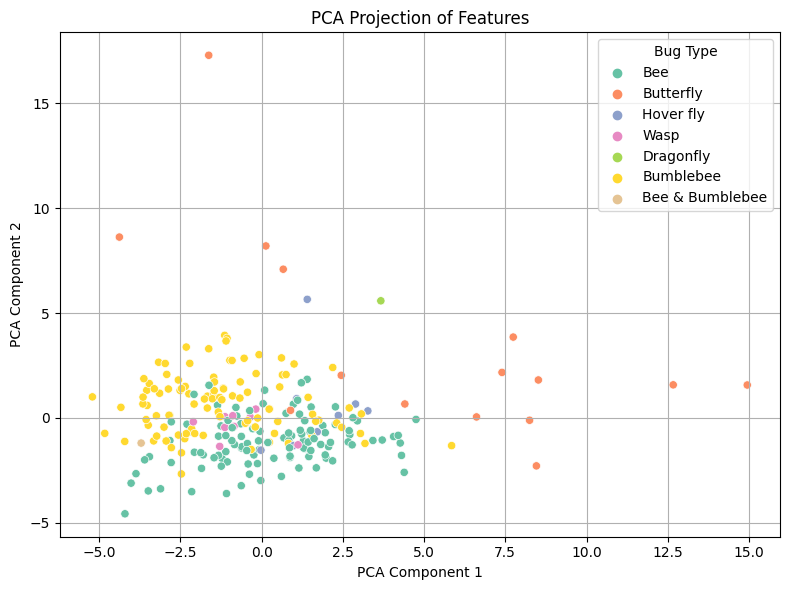

In [52]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='Set2')
plt.title("PCA Projection of Features")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Bug Type")
plt.grid(True)
plt.tight_layout()
plt.show()

* Dominant Classes: Bee and Bumblebee are the most numerous classes in this projection, forming an overlap of points in the left bottom side of our graph meaning they're not greatly separated by the first two principal components.
* Minority Classes & Outliers:
    * Butterfly are quite scattered and often appear as outliers or distinct from the main mass.
    * Hover fly and Wasp has even fewer points that are somewhat interspersed within the Bee/Bumblebee clusters.
    * Dragonfly has very few points since their features make them somewhat distinct.

    🔥 Due to the low number of samples, any model will struggle to learn robust patterns for these classes. They are also often embedded within or near the larger Bee/Bumblebee clusters, suggesting feature similarity in this PCA projection. We might have to use class_weight=balanced in our models later.

*Let's check feature importance*

In [53]:
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=features_df.index)
feature_names = X_scaled_df.columns

loadings_df = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=feature_names)

print("--- Loadings for PC1 (sorted by absolute contribution) ---")
print(loadings_df.reindex(loadings_df.PC1.abs().sort_values(ascending=False).index)[['PC1']].head(10))

print("\n--- Loadings for PC2 (sorted by absolute contribution) ---")
print(loadings_df.reindex(loadings_df.PC2.abs().sort_values(ascending=False).index)[['PC2']].head(10))

--- Loadings for PC1 (sorted by absolute contribution) ---
               PC1
g_mean    0.348885
g_median  0.344528
b_mean    0.341705
b_median  0.338230
r_mean    0.337246
r_median  0.332862
r_min     0.250968
g_min     0.235682
b_min     0.233695
b_std     0.137429

--- Loadings for PC2 (sorted by absolute contribution) ---
                               PC2
pixel_ratio_bug_to_total  0.414331
bug_area                  0.413862
obb_area                  0.398676
symmetry_score            0.364146
inscribed_circle_radius   0.313377
r_std                     0.269774
g_std                     0.217761
r_max                     0.156684
b_std                     0.151856
g_max                     0.147956


* Overall color intensity, impacting PC1, appears to be vital in distinguishing Butterflies which are brighter from Bees/Bumblebees.
* Size, symmetry, and color variation, impacting PC2, contribute in showing diversity within the Butterfly group and potentially some separation between Bee and Bumblebee along this axis though there's still overlap.
* Hypotheses for Modeling:
    * Models sensitive to linear combinations of features like Logistic Regression or Linear SVM might leverage these PC directions.
    * Tree-based models like Random Forest might pick up on these important features directly by finding good split points on them.

#### t-SNE Plot

C:\Users\DELL\anaconda3\envs\myenv\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


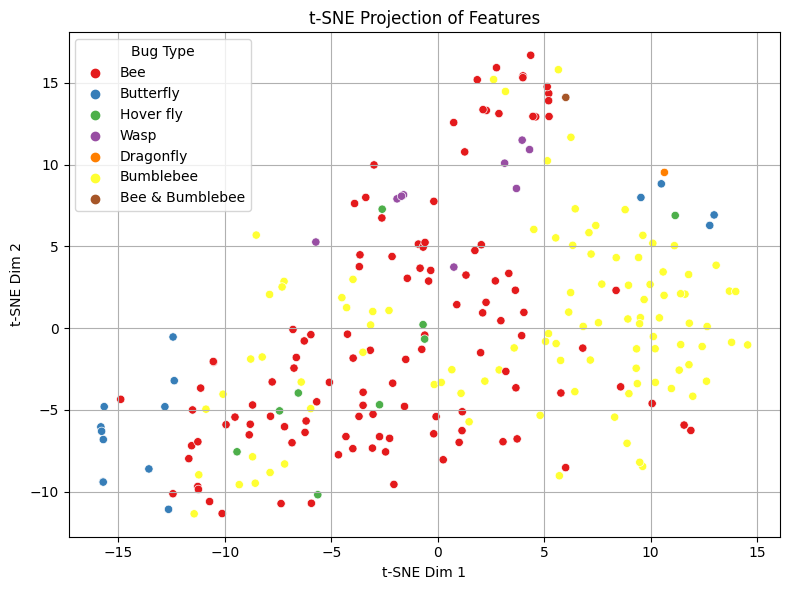

In [54]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette='Set1')
plt.title("t-SNE Projection of Features")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.legend(title="Bug Type")
plt.grid(True)
plt.tight_layout()
plt.show()

* Dominant Classes : There's a large overlap between Bee and Bumblebee points, spanning from negative to positive values on t-SNE Dim 1 reinforcing the idea from PCA that these two are difficult to distinguish.
    
* Minority classes & outliers :
    * The Butterfly points form a relatively tight and distinct cluster revealing how distinct they are from other groups.
    * The Hover fly points are somewhat scattered but tend to appear within the Bee/Bumblee overlap, suggesting they share many feature characteristics the latter.
    * Wasp points are few and are also embedded within the main Bee/Bumblebee cloud, mostly in the upper-central and upper-right regions. They don't form a distinct cluster. This again suggests high similarity to bees/bumblebees based on your features.
    * Dragonfly have very few points which don't seem to cleanly group with any major class.
    * The Bee & Bumblebee points are scattered overlapping with both distinct classes in that region highlighting their similarity.
    
    🔥 Good potential for classifying Butterflies.
    
    🔥 Significant difficulty in separating Bees from Bumblebees.
    
    🔥 High difficulty for other minority classes (Wasp, Hover fly, Dragonfly) due to both low sample size and feature similarity to the major classes.

#### UMAP Plot

C:\Users\DELL\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\DELL\anaconda3\envs\myenv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


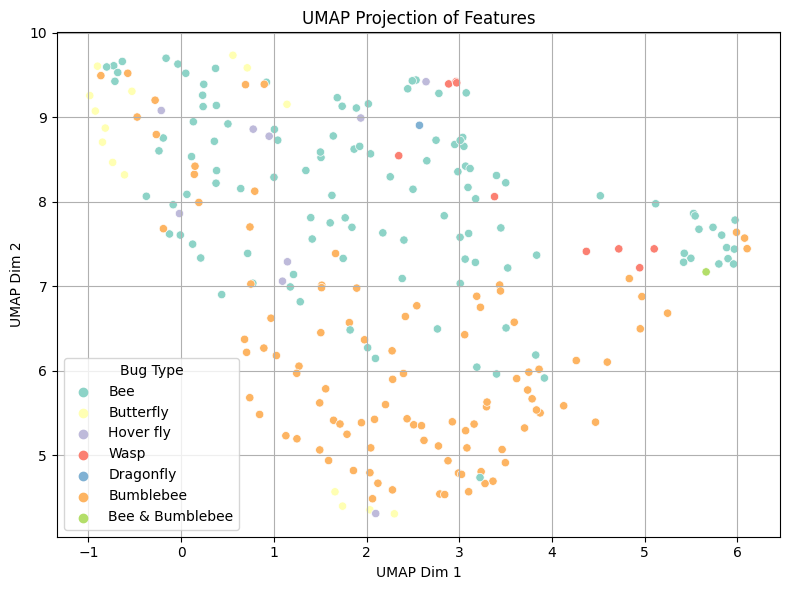

In [55]:
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=y, palette='Set3')
plt.title("UMAP Projection of Features")
plt.xlabel("UMAP Dim 1")
plt.ylabel("UMAP Dim 2")
plt.legend(title="Bug Type")
plt.grid(True)
plt.tight_layout()
plt.show()

This UMAP plot largely reinforces the findings from PCA and t-SNE:

  * Butterflies are somewhat distinguishable, forming clusters.
  * Bees and Bumblebees are very hard to separate with the features.
  * Other minority classes are heavily overlapped with Bees/Bumblebees.

#### Bug Type Distribution

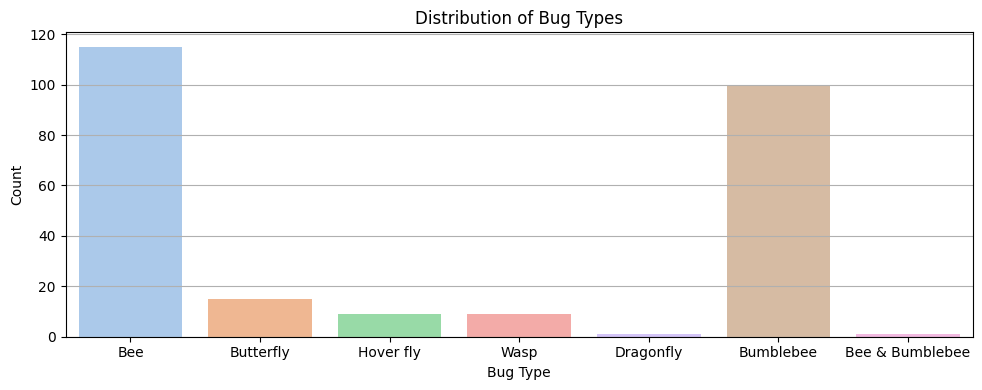

In [56]:
plt.figure(figsize=(10, 4))
sns.countplot(data=features_df, x='bug_type', palette='pastel')
plt.title("Distribution of Bug Types")
plt.xlabel("Bug Type")
plt.ylabel("Count")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

There is a remarkable class imbalance between our **7** different bug types with Bees and Bumblebees ([100;120]) dominating the distribution whereas the rest are well below 20 instances with Dragonfly and "Bee & Bumblebee" going as low as 2

#### Species Distribution

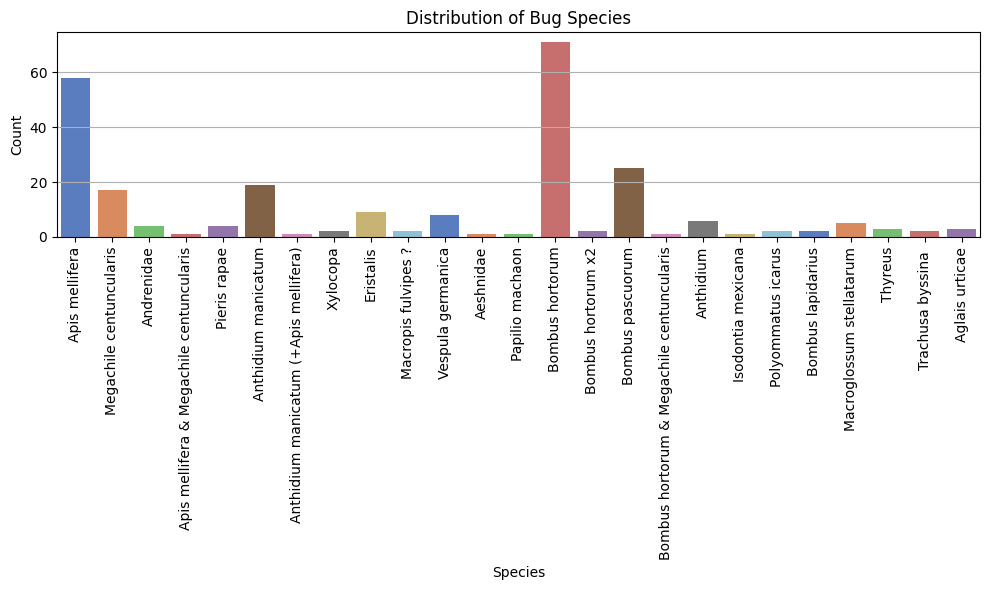

In [57]:
plt.figure(figsize=(10, 6))
sns.countplot(data=features_df, x='species', palette='muted')
plt.title("Distribution of Bug Species")
plt.xlabel("Species")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

There is, once again, a remarkable class imbalance between our **25** different bug species with "Bombus hortorum" and "Apis mellifera" (=>60) dominating the distribution, "Megachile centuncularis", "Anthidium manicatum" and "Bombus pascuorum" leveling around 20 instances each from total points and the rest being on the lower side (<10) 

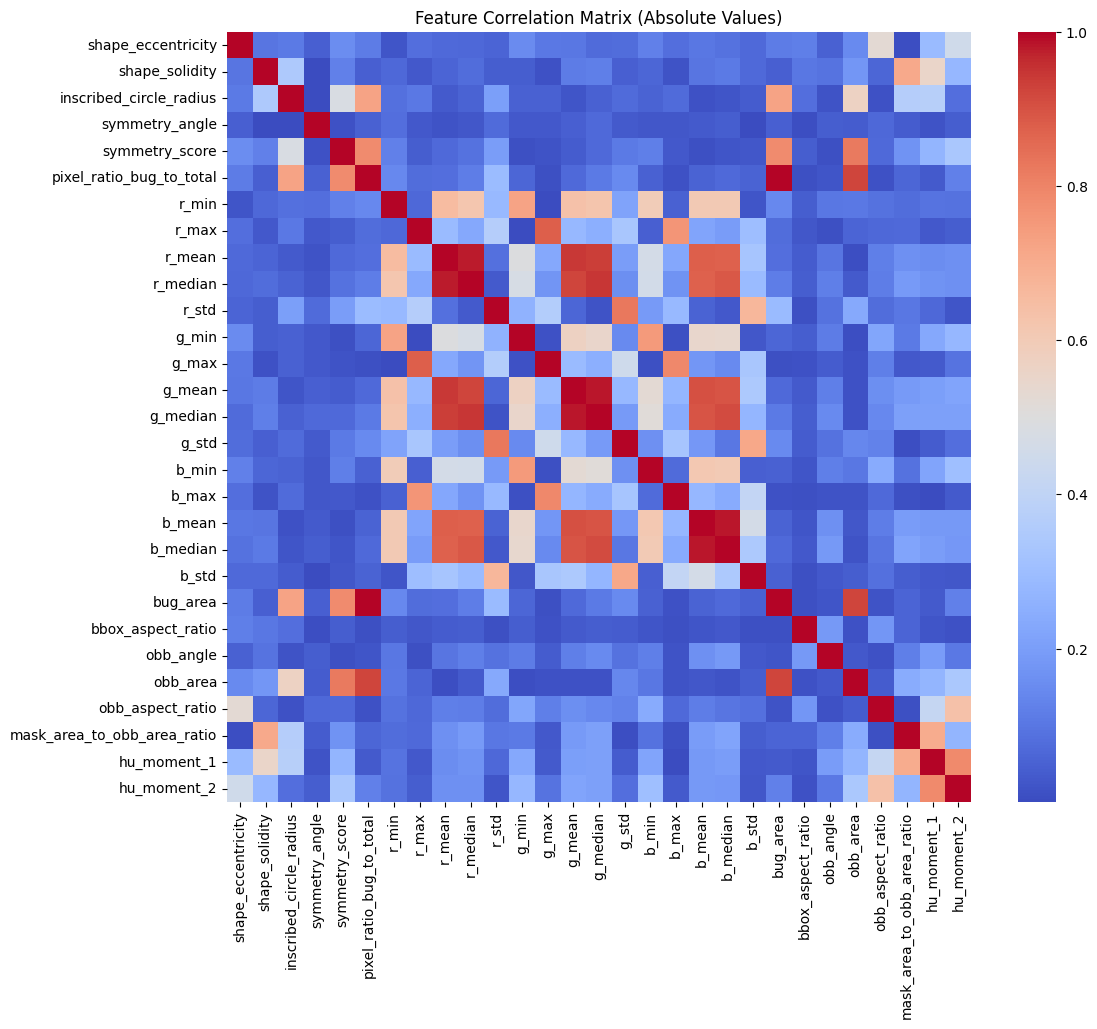


Features to potentially drop due to high correlation (>0.90): ['r_median', 'g_mean', 'g_median', 'b_mean', 'b_median', 'bug_area', 'obb_area']


In [58]:
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
correlation_matrix_pd = X_scaled_df.corr().abs() 

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_pd, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix (Absolute Values)')
plt.show()

# Find highly correlated pairs
upper = correlation_matrix_pd.where(np.triu(np.ones(correlation_matrix_pd.shape), k=1).astype(bool))
to_drop_corr = [column for column in upper.columns if any(upper[column] > 0.90)] # Example threshold 0.90
print(f"\nFeatures to potentially drop due to high correlation (>0.90): {to_drop_corr}")

Since "obb_area" was a personnal addition, we will drop it from our Dataframe as it correlates with "bug_area"

### 3. Data Preparation

#### Feature Selection

In [133]:
X = features_df.drop(columns=['id', 'bug_type', 'species', 'obb_area'])
y = features_df['bug_type']

#### Oversampling the 1-sample classes

"Bee & Bumblebee" and "Dragonfly" having only 1 instance in the training set is too limiting

We will oversample these to 2 in order to get past the stratification error

In [176]:
# Step 1: Use RandomOverSampler to bring 1-sample classes to 2 samples minimum
target_classes = ['Bee & Bumblebee', 'Dragonfly']
min_count_ros = 5

ros_strategy = {
    label: min_count_ros
    for label in target_classes
    if Counter(y)[label] < min_count_ros
}

if ros_strategy:
    ros = RandomOverSampler(sampling_strategy=ros_strategy, random_state=42)
    X_ros, y_ros = ros.fit_resample(X, y)
else:
    X_ros, y_ros = X, y

# Step 2: apply SMOTE for classes with more than 2 samples
desired_min_count_smote = 6

smote_strategy = {
    label: desired_min_count_smote
    for label in Counter(y_ros)
    if Counter(y_ros)[label] < desired_min_count_smote
}

if smote_strategy:
    smote = SMOTE(sampling_strategy=smote_strategy, random_state=42, k_neighbors=4)
    X_final, y_final = smote.fit_resample(X_ros, y_ros)
else:
    X_final, y_final = X_ros, y_ros

print("Final class distribution:")
print(Counter(y_final))

Final class distribution:
Counter({'Bee': 115, 'Bumblebee': 100, 'Butterfly': 15, 'Hover fly': 9, 'Wasp': 9, 'Dragonfly': 6, 'Bee & Bumblebee': 6})


#### Train/Test Split

"Stratified shuffle split" instead of the regular "Train/Test split" so i'm sure my splits have one instance from each class

In [177]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in sss.split(X_final, y_final):
    X_train, X_test = X_final.iloc[train_idx], X_final.iloc[test_idx]
    y_train, y_test = y_final.iloc[train_idx], y_final.iloc[test_idx]

#### Standardize

In [178]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 4. Modelling

#### Logistic Regression

In [179]:
param_grid_logreg = [
    {'penalty': ['l1'], 'solver': ['liblinear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'penalty': ['l2'], 'solver': ['liblinear', 'saga'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}
]

logreg = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    param_grid=param_grid_logreg,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
logreg.fit(X_train_scaled, y_train)
print(f"Best Params: {logreg.best_params_}")
print(f"Best CV Accuracy: {logreg.best_score_:.4f}")
best_logreg_model = logreg.best_estimator_
y_pred_logreg = best_logreg_model.predict(X_train_scaled)
y_pred_logreg_test = best_logreg_model.predict(X_test_scaled) # Predict on TEST features

print("\n=== Logistic Regression: EVALUATION ON TRAIN SET ===")
print("Accuracy:", accuracy_score(y_train, y_pred_logreg))
print(classification_report(y_train, y_pred_logreg, zero_division=0))

print("\n=== Logistic Regression: EVALUATION ON TEST SET ===")
# Evaluate against TEST labels
print("Accuracy on Test Set:", accuracy_score(y_test, y_pred_logreg_test))
print("Macro F1 Score:", f1_score(y_test, y_pred_logreg_test, average='macro'))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred_logreg_test))
print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred_logreg_test, zero_division=0))

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Params: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Best CV Accuracy: 0.7885

=== Logistic Regression: EVALUATION ON TRAIN SET ===
Accuracy: 0.9134615384615384
                 precision    recall  f1-score   support

            Bee       0.95      0.89      0.92        92
Bee & Bumblebee       1.00      1.00      1.00         5
      Bumblebee       0.93      0.93      0.93        80
      Butterfly       1.00      1.00      1.00        12
      Dragonfly       1.00      1.00      1.00         5
      Hover fly       0.50      0.86      0.63         7
           Wasp       0.75      0.86      0.80         7

       accuracy                           0.91       208
      macro avg       0.88      0.93      0.90       208
   weighted avg       0.93      0.91      0.92       208


=== Logistic Regression: EVALUATION ON TEST SET ===
Accuracy on Test Set: 0.7692307692307693
Macro F1 Score: 0.6597402597402597
Balanced 

* Overfitting: The drop from 91% training accuracy (or 78% CV accuracy) to 76.9% test accuracy clearly indicates that the model is overfitting to the training data. It has learned patterns specific to the training set that do not generalize well to unseen data.
* Impact of extreme minority classes: 
    * The model's inability to learn from classes with synthesized samples (Bee & Bumblebee, Dragonfly) is evident in both training and test sets. While it achieved 1.00 training recall for Dragonfly by memorizing it, this doesn't translate.
    * The poor performance on Wasp and Hover fly  is also due to their low representation.
* Logistic Regression actually performs most fairly across all classes, as seen in Macro F1 and Balanced Accuracy
    ➤ It’s not overfitting to majority classes.

#### SVM

In [180]:
param_grid_svm = {'C': [0.1, 1, 10], 
                  'gamma': [0.01, 0.1, 1], 
                  'kernel': ['rbf', 'linear']}
svm_model = GridSearchCV(
    SVC(probability=True, random_state=42, class_weight='balanced'), 
    param_grid_svm, 
    cv=5, 
    scoring='accuracy') 
svm_model.fit(X_train_scaled, y_train)
print(f"Best Params: {svm_model.best_params_}")
print(f"Best CV Accuracy: {svm_model.best_score_:.4f}")

best_svm_model = svm_model.best_estimator_
y_pred_svm = best_svm_model.predict(X_train_scaled)
y_pred_svm_test = best_svm_model.predict(X_test_scaled)

print("\n=== Support Vector Machine (SVM) : EVALUATION ON TRAIN SET ===")
print("Accuracy:", accuracy_score(y_train, y_pred_svm))
print(classification_report(y_train, y_pred_svm, zero_division=0))

print("\n=== Support Vector Machine (SVM) : EVALUATION ON TEST SET ===")
print("Accuracy:", accuracy_score(y_test, y_pred_svm_test))
print("Macro F1 Score:", f1_score(y_test, y_pred_svm_test, average='macro'))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred_svm_test))
print(classification_report(y_test, y_pred_svm_test, zero_division=0))

Best Params: {'C': 10, 'gamma': 0.01, 'kernel': 'linear'}
Best CV Accuracy: 0.8079

=== Support Vector Machine (SVM) : EVALUATION ON TRAIN SET ===
Accuracy: 0.9663461538461539
                 precision    recall  f1-score   support

            Bee       0.98      0.95      0.96        92
Bee & Bumblebee       1.00      1.00      1.00         5
      Bumblebee       0.94      0.97      0.96        80
      Butterfly       1.00      1.00      1.00        12
      Dragonfly       1.00      1.00      1.00         5
      Hover fly       1.00      1.00      1.00         7
           Wasp       1.00      1.00      1.00         7

       accuracy                           0.97       208
      macro avg       0.99      0.99      0.99       208
   weighted avg       0.97      0.97      0.97       208


=== Support Vector Machine (SVM) : EVALUATION ON TEST SET ===
Accuracy: 0.7884615384615384
Macro F1 Score: 0.6189028803010566
Balanced Accuracy: 0.6275362318840579
                 precision   

* Better generalization: The SVM with a linear kernel and C=10 shows better generalization to the test set (78.8% accuracy) compared to the Logistic Regression (76.9% accuracy). The gap between its CV/training accuracy and test accuracy is bigger, indicating more overfitting.
* Linear kernel choice: The fact that GridSearchCV selected a linear kernel suggests that the features are linearly separable enough for the SVM to find a good hyperplane.
* Extreme minority classes are still a problem: "Wasp" and "Hoverfly" (2 sample in test) remain unlearnable.
* SVM has slightly better raw accuracy but is more biased toward majority classes (lower Macro F1).

#### Random Forest (Ensemble)

In [181]:
param_grid_rf = {'n_estimators': [50, 100, 200], 
                 'max_depth': [3, 5, 10, 20], 
                 'min_samples_split': [2, 5]}
rf_model = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'), 
    param_grid_rf, 
    cv=3, 
    scoring='accuracy')
rf_model.fit(X_train_scaled, y_train)
print(f"Best Params: {rf_model.best_params_}")
print(f"Best CV Accuracy: {rf_model.best_score_:.4f}")

best_rf_model = rf_model.best_estimator_
y_pred_rf = best_rf_model.predict(X_train_scaled)
y_pred_rf_test = best_rf_model.predict(X_test_scaled)

print("\n=== Random Forest (Ensemble): EVALUATION ON TRAIN SET ===")
print("Accuracy:", accuracy_score(y_train, y_pred_rf))
print(classification_report(y_train, y_pred_rf, zero_division=0))

print("\n=== Random Forest (Ensemble): EVALUATION ON TEST SET ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf_test))
print("Macro F1 Score:", f1_score(y_test, y_pred_rf_test, average='macro'))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred_rf_test))
print(classification_report(y_test, y_pred_rf_test, zero_division=0))

Best Params: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 200}
Best CV Accuracy: 0.7788

=== Random Forest (Ensemble): EVALUATION ON TRAIN SET ===
Accuracy: 0.9182692307692307
                 precision    recall  f1-score   support

            Bee       0.94      0.88      0.91        92
Bee & Bumblebee       1.00      1.00      1.00         5
      Bumblebee       0.89      0.93      0.91        80
      Butterfly       1.00      1.00      1.00        12
      Dragonfly       1.00      1.00      1.00         5
      Hover fly       0.70      1.00      0.82         7
           Wasp       1.00      1.00      1.00         7

       accuracy                           0.92       208
      macro avg       0.93      0.97      0.95       208
   weighted avg       0.92      0.92      0.92       208


=== Random Forest (Ensemble): EVALUATION ON TEST SET ===
Accuracy: 0.6730769230769231
Macro F1 Score: 0.49173955296404276
Balanced Accuracy: 0.5083850931677019
                 prec

* Overfitting: The 100% training accuracy followed by 67% test accuracy is a textbook example of overfitting. The trees are too complex and have learned the noise and specific details of the training set rather than generalizable patterns.
* Performance on majority classes: It performs reasonably well on "Bee" and "Bumblebee" in the test set, similar to the other models.
* Failure on minority classes (Test Set): Despite perfectly "learning" the oversamples and synthesized classes and minorities in the training set, this knowledge doesn't generalize to the test set.
* Random Forest is underperforming, likely because:
    * It struggles with very small or oversampled classes
    * It might be overfitting on majority even with class_weight='balanced'
    * RFs tend to do worse with synthesized data or when classes are too imbalanced

#### XGBoost

Since RandomForest performed too poorly, it would be interesting to try XGBoost (an ensemble model) since it handles class imbalance a lot better

Heavily relying on this source (https://xgboost.readthedocs.io/en/stable/python/python_intro.html)

In [183]:
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Create DMatrix with encoded labels
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_encoded, weight=weights_array)
dtest = xgb.DMatrix(X_test_scaled, label=y_test_encoded)

num_classes = len(np.unique(y_train))

# Class weights
counter = Counter(y_train_encoded)
total = sum(counter.values())
weights = {cls: total/count for cls, count in counter.items()}
weights_array = np.array([weights[label] for label in y_train_encoded])

params = {
    'objective': 'multi:softprob',
    'num_class': num_classes,
    'eval_metric': 'mlogloss',
    'eta': 0.1,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42,
}

bst = xgb.train(params, dtrain, num_boost_round=100,
                evals=[(dtrain, 'train')],
                verbose_eval=10,
                early_stopping_rounds=10,)

y_pred_proba = bst.predict(dtest)
y_pred = np.argmax(y_pred_proba, axis=1)

print("Accuracy:", accuracy_score(y_test_encoded, y_pred))
print("Balanced Accuracy:", balanced_accuracy_score(y_test_encoded, y_pred))
print("Macro F1 Score:", f1_score(y_test_encoded, y_pred, average='macro'))
print("\nClassification Report:\n", classification_report(y_test_encoded, y_pred, zero_division=0))
y_pred_labels = label_encoder.inverse_transform(y_pred)

[0]	train-mlogloss:1.66522
[10]	train-mlogloss:0.58165
[20]	train-mlogloss:0.24863
[30]	train-mlogloss:0.11417
[40]	train-mlogloss:0.05671
[50]	train-mlogloss:0.03123
[60]	train-mlogloss:0.01908
[70]	train-mlogloss:0.01298
[80]	train-mlogloss:0.00974
[90]	train-mlogloss:0.00793
[99]	train-mlogloss:0.00689
Accuracy: 0.6923076923076923
Balanced Accuracy: 0.59648033126294
Macro F1 Score: 0.5833981291675503

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.61      0.65        23
           1       1.00      1.00      1.00         1
           2       0.67      0.90      0.77        20
           3       0.67      0.67      0.67         3
           4       1.00      1.00      1.00         1
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         2

    accuracy                           0.69        52
   macro avg       0.58      0.60      0.58        52
weighted avg       0.64   

This reflects a decent overall performance, especially given the severe class imbalance — but the macro F1 and balanced accuracy clearly show that the model is still biased toward the dominant classes.

The results are much better than that of Random Forest but still underwhelming compared to the linear models (LR and SVM) but it was still worth a try!

#### KMeans Clustering

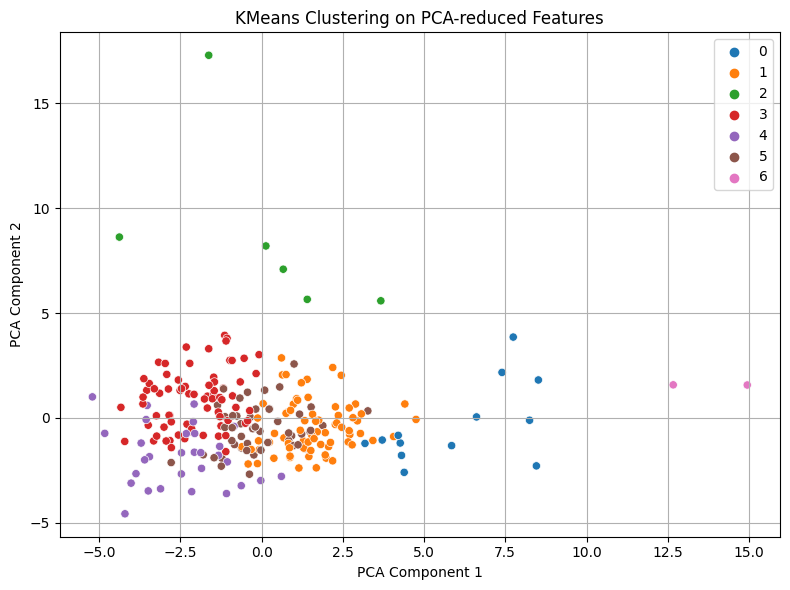

In [184]:
# We expect as many clusters as bug types which is why we'll use len(y.unique())
kmeans = KMeans(n_clusters=len(y.unique()), random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Reduce dimensions for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot KMeans clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans_labels, palette='tab10', legend='full')
plt.title("KMeans Clustering on PCA-reduced Features")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()

In [185]:
silhouette_avg = silhouette_score(X_scaled, kmeans_labels)
davies_bouldin = davies_bouldin_score(X_scaled, kmeans_labels)
calinski_harabasz = calinski_harabasz_score(X_scaled, kmeans_labels)
inertia = kmeans.inertia_

print(f"  Inertia (Within-cluster sum of squares): {inertia:.2f}")
print(f"  Silhouette Score: {silhouette_avg:.4f}")
print(f"  Davies-Bouldin Index: {davies_bouldin:.4f}")
print(f"  Calinski-Harabasz Index: {calinski_harabasz:.4f}")

  Inertia (Within-cluster sum of squares): 4003.75
  Silhouette Score: 0.1352
  Davies-Bouldin Index: 1.6856
  Calinski-Harabasz Index: 32.8375


* Silhouette score ranges from -1 to +1 (Higher is better) so a score of 0.1352 is very low, indicating poorly defined clusters and significant overlap between clusters

* Davies-Bouldin Index' lower values are better, (0 indicates perfect clustering) so a score of 1.6856 is relatively high, suggesting that clusters are not well separated and/or are quite dispersed.

#### Agglomerative Clustering


  Cross-tabulation of Agglomerative clusters vs True Bug Types:
Agglo Cluster             0  1   2  3   4  5   6
True Bug Type (Numeric)                         
Bee                      36  0   7  6  51  0  15
Bee & Bumblebee           0  0   0  0   0  0   1
Bumblebee                35  0  43  1  15  0   6
Butterfly                 0  4   0  6   3  2   0
Dragonfly                 0  1   0  0   0  0   0
Hover fly                 1  0   2  0   6  0   0
Wasp                      5  0   0  0   1  0   3


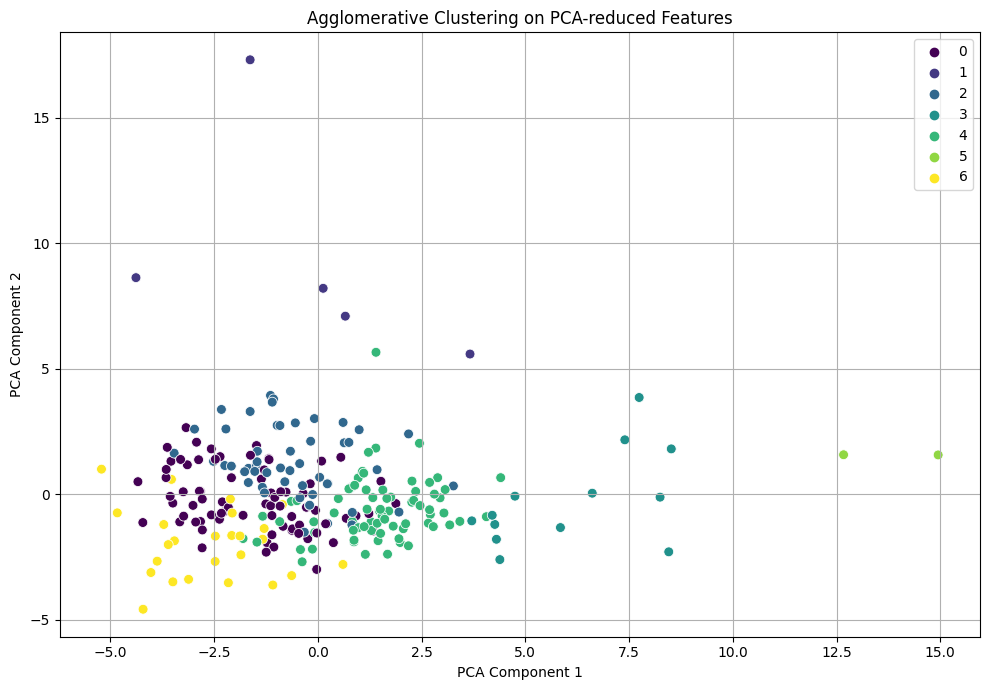

In [186]:
agg_clustering = AgglomerativeClustering(n_clusters=len(np.unique(y)), linkage='ward')
agg_labels = agg_clustering.fit_predict(X_scaled)

if 'y' in locals() and len(y) == len(agg_labels): # Check if 'y' (numeric true labels) exists
    y_true_for_eval_agg = y
    print("\n  Cross-tabulation of Agglomerative clusters vs True Bug Types:")
    if 'y_true_labels_str' in locals() and len(y_true_labels_str) == len(agg_labels):
         print(pd.crosstab(y_true_labels_str, agg_labels, rownames=['True Bug Type'], colnames=['Agglo Cluster']))
    else:
        print(pd.crosstab(pd.Series(y_true_for_eval_agg, name='True Bug Type (Numeric)'), 
                          pd.Series(agg_labels, name='Agglo Cluster')))

plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=agg_labels, 
                palette='viridis', legend='full', s=50) # Different palette
plt.title(f"Agglomerative Clustering on PCA-reduced Features")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()

In [187]:
silhouette_agg = silhouette_score(X_scaled, agg_labels)
davies_bouldin_agg = davies_bouldin_score(X_scaled, agg_labels)
calinski_harabasz_agg = calinski_harabasz_score(X_scaled, agg_labels)

print(f"  Silhouette Score: {silhouette_agg:.4f}")
print(f"  Davies-Bouldin Index: {davies_bouldin_agg:.4f}")
print(f"  Calinski-Harabasz Index: {calinski_harabasz_agg:.4f}")

  Silhouette Score: 0.1093
  Davies-Bouldin Index: 1.7738
  Calinski-Harabasz Index: 29.6290


The results aren't much different from K-Means which aren't satisfying

#### Stochastic Gradient Descent

In [188]:
param_grid_sgd = [
    {
        'loss': ['log_loss'], # Logistic Regression like
        'penalty': ['l2', 'l1', 'elasticnet'],
        'alpha': [0.0001, 0.001, 0.01, 0.1],
        'learning_rate': ['optimal', 'adaptive'],
        'eta0': [0.01, 0.1]
    },
    {
        'loss': ['hinge'], # Linear SVM like
        'penalty': ['l2', 'l1', 'elasticnet'],
        'alpha': [0.0001, 0.001, 0.01, 0.1],
        'learning_rate': ['optimal', 'adaptive'],
        'eta0': [0.01, 0.1]
    }
]


sgd_clf_estimator = SGDClassifier(
    max_iter=1000, 
    tol=1e-3, 
    random_state=42, 
    class_weight='balanced', 
    early_stopping=False, 
    n_iter_no_change=10, 
    validation_fraction=0.1)

# Initialize GridSearchCV
sgd_clf = GridSearchCV(
    estimator=sgd_clf_estimator,
    param_grid=param_grid_sgd,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print("Fitting GridSearchCV for SGD Classifier...")
sgd_clf.fit(X_train_scaled, y_train)

print(f"\nBest Parameters for SGD Classifier: {sgd_clf.best_params_}")
print(f"Best CV Accuracy for SGD Classifier: {sgd_clf.best_score_:.4f}")

best_sgd_model = sgd_clf.best_estimator_

print("\n=== SGD Classifier: EVALUATION ON TRAIN SET ===")
y_pred_sgd = best_sgd_model.predict(X_train_scaled)
print("Accuracy on Original Training Set:", accuracy_score(y_train, y_pred_sgd))
print("Classification Report on Original Training Set:")
print(classification_report(y_train, y_pred_sgd, zero_division=0))

print("\n=== SGD Classifier: EVALUATION ON TEST SET ===")
y_pred_sgd_test = best_sgd_model.predict(X_test_scaled)
print("Accuracy on Test Set:", accuracy_score(y_test, y_pred_sgd_test))
print("Macro F1 Score:", f1_score(y_test, y_pred_sgd_test, average='macro'))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred_sgd_test))
print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred_sgd_test, zero_division=0))

Fitting GridSearchCV for SGD Classifier...
Fitting 3 folds for each of 96 candidates, totalling 288 fits

Best Parameters for SGD Classifier: {'alpha': 0.001, 'eta0': 0.01, 'learning_rate': 'optimal', 'loss': 'log_loss', 'penalty': 'elasticnet'}
Best CV Accuracy for SGD Classifier: 0.7981

=== SGD Classifier: EVALUATION ON TRAIN SET ===
Accuracy on Original Training Set: 0.9230769230769231
Classification Report on Original Training Set:
                 precision    recall  f1-score   support

            Bee       0.92      0.91      0.92        92
Bee & Bumblebee       1.00      1.00      1.00         5
      Bumblebee       0.92      0.91      0.92        80
      Butterfly       1.00      1.00      1.00        12
      Dragonfly       1.00      1.00      1.00         5
      Hover fly       0.67      0.86      0.75         7
           Wasp       1.00      1.00      1.00         7

       accuracy                           0.92       208
      macro avg       0.93      0.95      0.

SGD, here, behaves like a linear model (similar to the LR and linear SVM models we implemented), but it's faster.

#### MLP (Multilayer Perceptron)

In [189]:
X_for_dl_preparation = X_train_scaled
y_for_dl_preparation = y_train

X_train_dl, X_val_dl, y_train_dl, y_val_dl = train_test_split(
    X_dl_temp_resampled, y_dl_temp_resampled, 
    test_size=0.15, 
    random_state=42, 
    stratify=y_dl_temp_resampled
)

print(f"\nDL Training data shape: {X_train_dl.shape}, DL Validation data shape: {X_val_dl.shape}")
print(f"DL Training labels distribution: {Counter(y_train_dl)}")
print(f"DL Validation labels distribution: {Counter(y_val_dl)}")


DL Training data shape: (171, 28), DL Validation data shape: (31, 28)
DL Training labels distribution: Counter({'Bee': 73, 'Bumblebee': 69, 'Butterfly': 11, 'Hover fly': 7, 'Wasp': 7, 'Dragonfly': 2, 'Bee & Bumblebee': 2})
DL Validation labels distribution: Counter({'Bee': 13, 'Bumblebee': 13, 'Hover fly': 2, 'Butterfly': 2, 'Wasp': 1})


In [190]:
# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=15,         # Nb of epochs with no improvement 
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, # Factor by which the learning rate will be reduced
    patience=7,  # Nb of epochs with no improvement
    min_lr=0.00001, # lower bound on the lr
    verbose=1
)

NEURONS_L1 = 128
NEURONS_L2 = 64
DROPOUT = 0.4
LEARNING_RATE = 0.001 
EPOCHS = 150 # EarlyStopping will handle it first
BATCH_SIZE = 32

# Build the model
dl_model = build_mlp_model(input_dim, num_classes, 
                           neurons1=NEURONS_L1, neurons2=NEURONS_L2, 
                           dropout_rate=DROPOUT, learning_rate=LEARNING_RATE)
dl_model.summary() 

# Encode string labels to integers
label_encoder = LabelEncoder()
label_encoder.fit(y) 
y_train_dl_encoded = label_encoder.transform(y_train_dl)
y_val_dl_encoded = label_encoder.transform(y_val_dl)

class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train_dl_encoded),
    y=y_train_dl_encoded
)
class_weights = dict(enumerate(class_weights))

# Train the model
print("\n--- Training Deep Learning MLP Model ---")
history = dl_model.fit(X_train_dl, y_train_dl_encoded,
                       class_weight=class_weights,
                       epochs=EPOCHS,
                       batch_size=BATCH_SIZE,
                       validation_data=(X_val_dl, y_val_dl_encoded),
                       callbacks=[early_stopping, reduce_lr],
                       verbose=1)

Model: "BugType_MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 128)               3712      
                                                                 
 batch_normalization_12 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 dense_19 (Dense)            (None, 64)                8256      
                                                                 
 batch_normalization_13 (Ba  (None, 64)                256       
 tchNormalization)                                               
                                                                 
 dropout_13 (Dropout)        (None, 64)                

6/6 [==============================] - 0s 8ms/step - loss: 0.3043 - accuracy: 0.7485 - val_loss: 0.5002 - val_accuracy: 0.8710 - lr: 0.0010
Epoch 45/150
6/6 [==============================] - 0s 8ms/step - loss: 0.3903 - accuracy: 0.7310 - val_loss: 0.4792 - val_accuracy: 0.9032 - lr: 0.0010
Epoch 46/150
6/6 [==============================] - 0s 9ms/step - loss: 0.2751 - accuracy: 0.7719 - val_loss: 0.4595 - val_accuracy: 0.9032 - lr: 0.0010
Epoch 47/150
6/6 [==============================] - 0s 8ms/step - loss: 0.3476 - accuracy: 0.7661 - val_loss: 0.4421 - val_accuracy: 0.9032 - lr: 0.0010
Epoch 48/150
6/6 [==============================] - 0s 8ms/step - loss: 0.3458 - accuracy: 0.7602 - val_loss: 0.4372 - val_accuracy: 0.9032 - lr: 0.0010
Epoch 49/150
6/6 [==============================] - 0s 8ms/step - loss: 0.3215 - accuracy: 0.7427 - val_loss: 0.4351 - val_accuracy: 0.9032 - lr: 0.0010
Epoch 50/150
6/6 [==============================] - 0s 8ms/step - loss: 0.2642 - accuracy: 0.80

6/6 [==============================] - 0s 9ms/step - loss: 0.1718 - accuracy: 0.8947 - val_loss: 0.2387 - val_accuracy: 0.9032 - lr: 0.0010
Epoch 98/150
6/6 [==============================] - 0s 9ms/step - loss: 0.1719 - accuracy: 0.8772 - val_loss: 0.2445 - val_accuracy: 0.9032 - lr: 0.0010
Epoch 99/150
6/6 [==============================] - 0s 8ms/step - loss: 0.1115 - accuracy: 0.9181 - val_loss: 0.2488 - val_accuracy: 0.9032 - lr: 0.0010
Epoch 100/150
6/6 [==============================] - 0s 8ms/step - loss: 0.1430 - accuracy: 0.9064 - val_loss: 0.2488 - val_accuracy: 0.9032 - lr: 0.0010
Epoch 101/150
1/6 [====>.........................] - ETA: 0s - loss: 0.1877 - accuracy: 0.9688
Epoch 101: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
6/6 [==============================] - 0s 8ms/step - loss: 0.1276 - accuracy: 0.8947 - val_loss: 0.2491 - val_accuracy: 0.9032 - lr: 0.0010
Epoch 102/150
6/6 [==============================] - 0s 8ms/step - loss: 0.2422 - accu

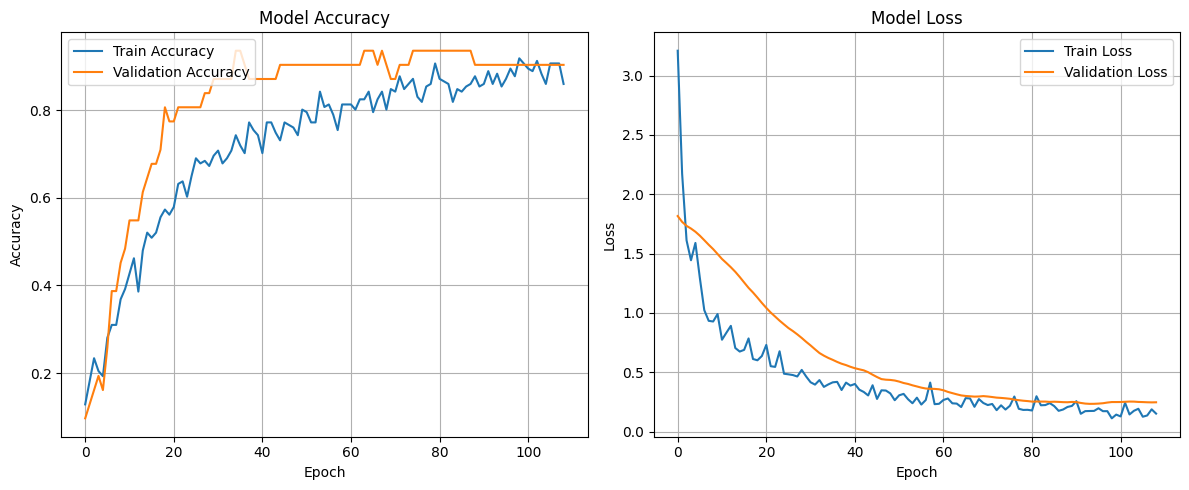


--- Deep Learning MLP: EVALUATION ON TEST SET ---
Test Loss: 0.2862
Test Accuracy: 0.9038
2/2 [==============================] - 0s 4ms/step

Classification Report on Test Set (Deep Learning MLP):
                 precision    recall  f1-score   support

            Bee       1.00      0.78      0.88        23
Bee & Bumblebee       1.00      1.00      1.00         1
      Bumblebee       0.83      1.00      0.91        20
      Butterfly       0.75      1.00      0.86         3
      Dragonfly       1.00      1.00      1.00         1
      Hover fly       1.00      1.00      1.00         2
           Wasp       1.00      1.00      1.00         2

       accuracy                           0.90        52
      macro avg       0.94      0.97      0.95        52
   weighted avg       0.92      0.90      0.90        52



In [191]:
# Plot training & validation accuracy and loss values
if history and history.history: 
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("Training history not available for plotting")


print("\n--- Deep Learning MLP: EVALUATION ON TEST SET ---")
y_test_encoded = label_encoder.transform(y_test)
loss_test, accuracy_test = dl_model.evaluate(X_test_scaled, y_test_encoded, verbose=0)
print(f"Test Loss: {loss_test:.4f}")
print(f"Test Accuracy: {accuracy_test:.4f}")

# Get predictions for classification report
y_pred_dl_proba = dl_model.predict(X_test_scaled)
y_pred_dl_classes = np.argmax(y_pred_dl_proba, axis=1) # Convert probabilities to class labels


print("\nClassification Report on Test Set (Deep Learning MLP):")
print(classification_report(y_test_encoded, 
                            y_pred_dl_classes, 
                            target_names=label_encoder.classes_, 
                            zero_division=0, 
                            labels=np.arange(len(label_encoder.classes_)),  # this ensures correct mapping
))

* Accuracy: 90.38% – the best results so far
* Macro F1 Score: 0.95
* Loss: 0.2862 - quite low implying confident predictions

### Evaluation

In [197]:
def evaluate_models(models_dict, X_test, y_test, label_encoder=None):    
    # Encode y_test if label_encoder given
    if label_encoder is not None:
        y_true = label_encoder.transform(y_test)
    else:
        y_true = y_test
    
    for name, model in models_dict.items():
        print(f"--- {name} ---")
        
        if name == "Deep Learning MLP":
            # For DL model, predict probabilities and convert to classes
            y_pred_proba = model.predict(X_test)
            y_pred = y_pred_proba.argmax(axis=1)
        else:
            y_pred = model.predict(X_test)
            if label_encoder is not None:
                # If other models use encoded y, encode predictions if needed
                # Only do if y_pred is strings but y_true is encoded ints
                # But usually they are consistent so skip here
                pass
        
        # Calculate metrics
        acc = accuracy_score(y_true, y_pred)
        bal_acc = balanced_accuracy_score(y_true, y_pred)
        macro_f1 = f1_score(y_true, y_pred, average='macro')
        
        print(f"Accuracy: {acc:.4f}")
        print(f"Balanced Accuracy: {bal_acc:.4f}")
        print(f"Macro F1 Score: {macro_f1:.4f}\n")
        
        # Print classification report with proper labels
        if label_encoder is not None:
            print(classification_report(
                y_true, y_pred,
                target_names=label_encoder.classes_,
                labels=np.arange(len(label_encoder.classes_)),
                zero_division=0
            ))
        else:
            print(classification_report(y_true, y_pred, zero_division=0))
        
        print("\n" + "-"*50 + "\n")

In [199]:
# List to store results
model_results = []

# Assuming you have predictions like y_pred_lr, y_pred_svm, etc.
evaluate_model("Logistic Regression", y_test, y_pred_logreg_test, model_results)
evaluate_model("SVM", y_test, y_pred_svm_test, model_results)
evaluate_model("Random Forest", y_test, y_pred_rf_test, model_results)
evaluate_model("XGBoost", y_test_encoded, y_pred, model_results)
evaluate_model("SGD Classifier", y_test, y_pred_sgd_test, model_results)
evaluate_model("MLP (Deep Learning)", y_test_encoded, y_pred_dl_classes, model_results)

In [200]:
df_results = pd.DataFrame(model_results)
df_results = df_results.sort_values(by="Accuracy", ascending=False)
display(df_results.round(4))

,Model,Accuracy,Macro F1,Balanced Accuracy
5,MLP (Deep Learning),0.9038,0.9492,0.9689
1,SVM,0.7885,0.6189,0.6275
0,Logistic Regression,0.7692,0.6597,0.6451
4,SGD Classifier,0.7500,0.6441,0.6380
3,XGBoost,0.6923,0.5834,0.5965
2,Random Forest,0.6731,0.4917,0.5084
